Пропущенные значения:
 Регион                     0
рейтинг                    0
безработица                0
продолжительность_жизни    0
средний_класс              0
средняя_зп                 0
пенсия                     0
цена_жилья                 8
инфляция                   0
год                        0
dtype: int64

Описательная статистика:
           рейтинг  безработица  продолжительность_жизни  средний_класс  \
count  425.000000   425.000000               425.000000     425.000000   
mean    49.187256     5.898588                71.348518      12.016471   
std     11.476862     3.995044                 2.649493       8.054863   
min     17.506000     1.300000                64.000000       1.400000   
25%     41.799000     3.600000                69.660000       6.600000   
50%     48.270000     4.800000                71.120000       9.600000   
75%     56.132000     6.700000                72.870000      13.800000   
max     83.640000    31.600000                79.870000

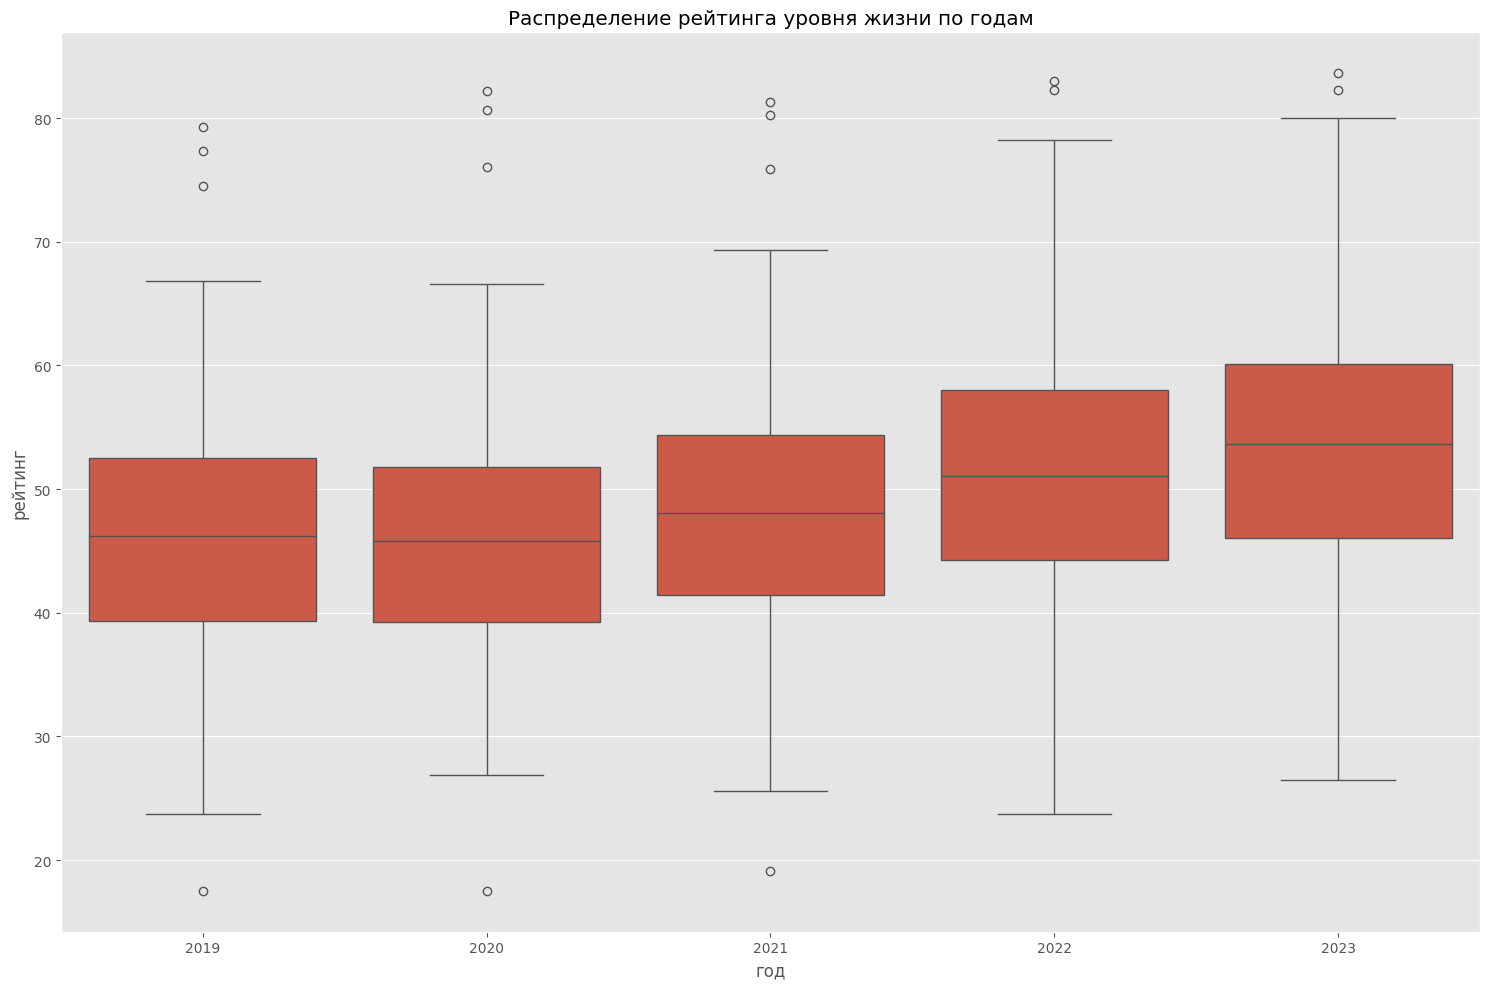

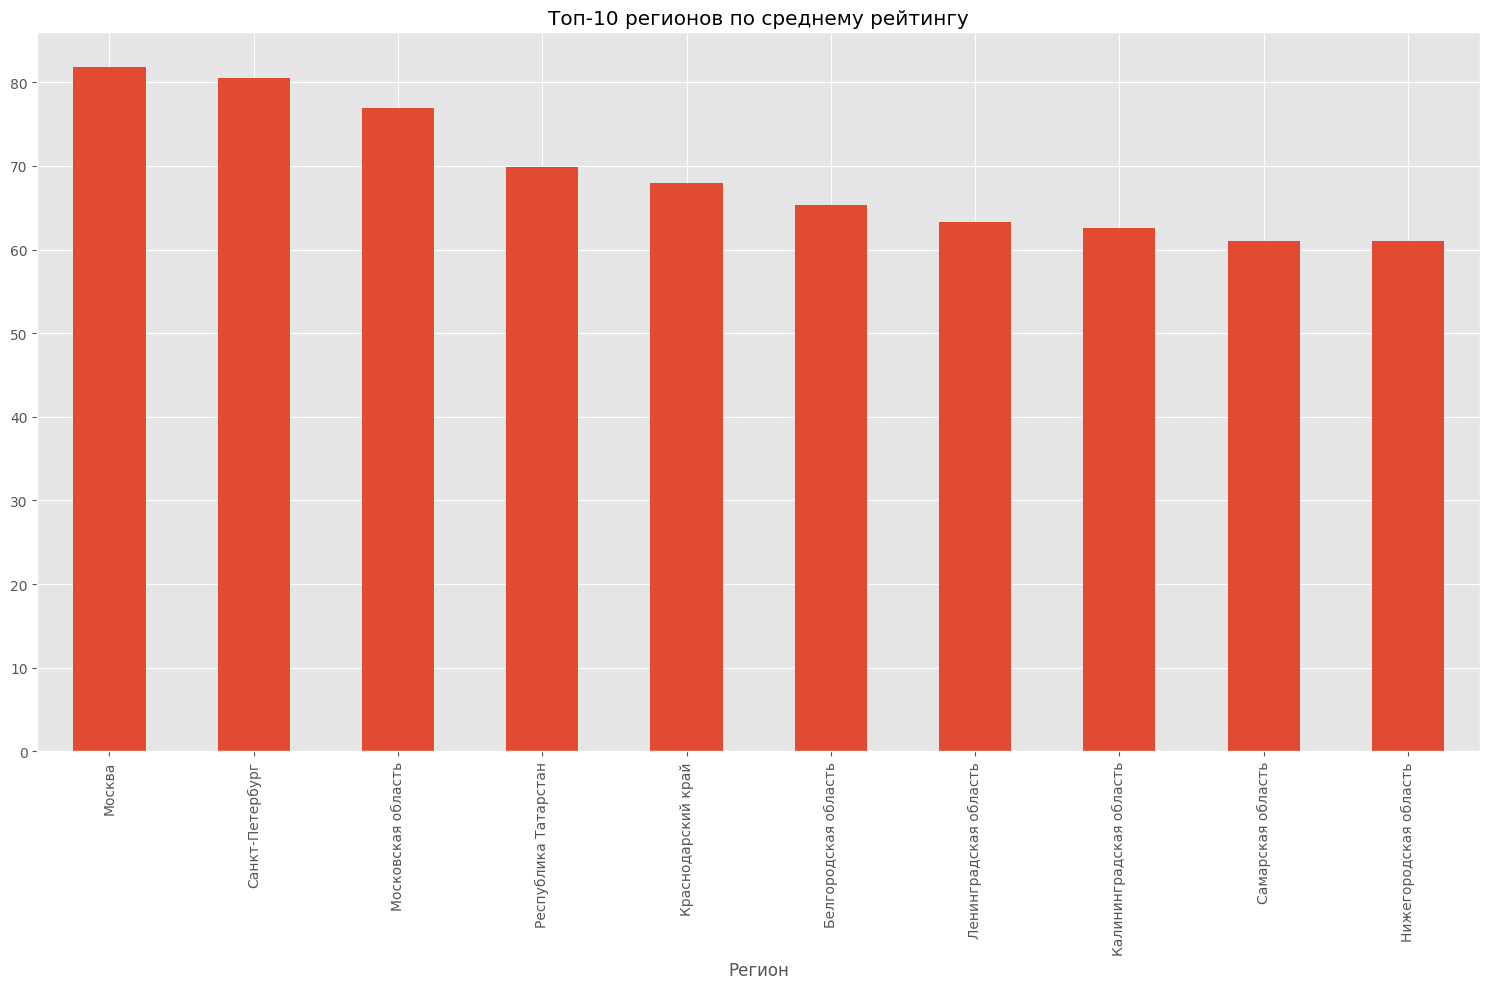

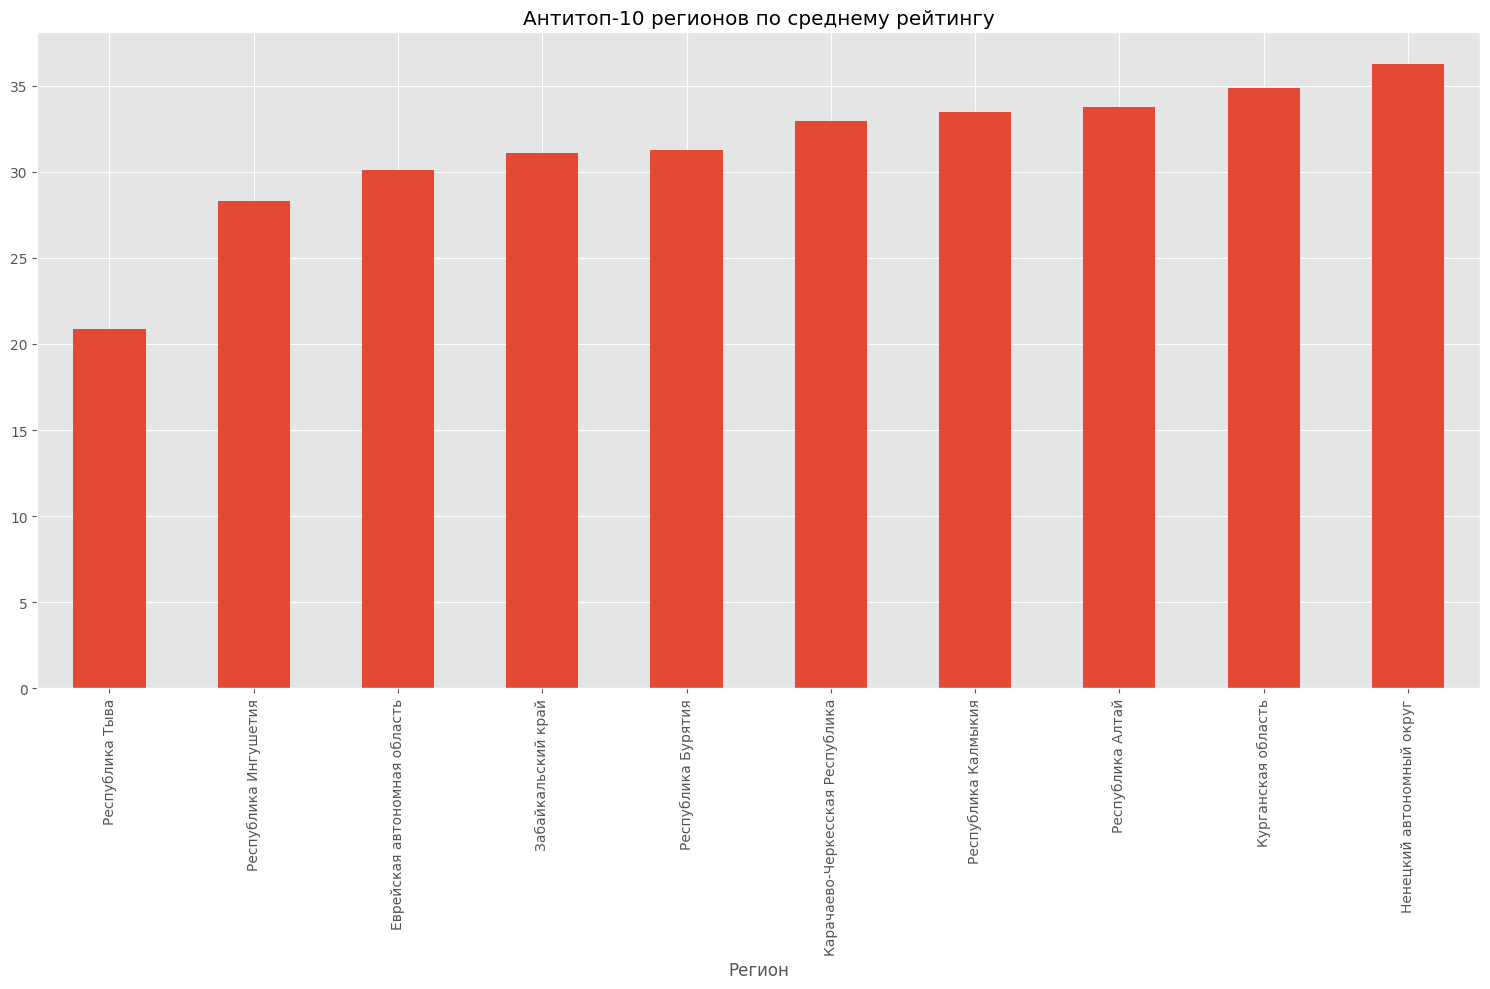

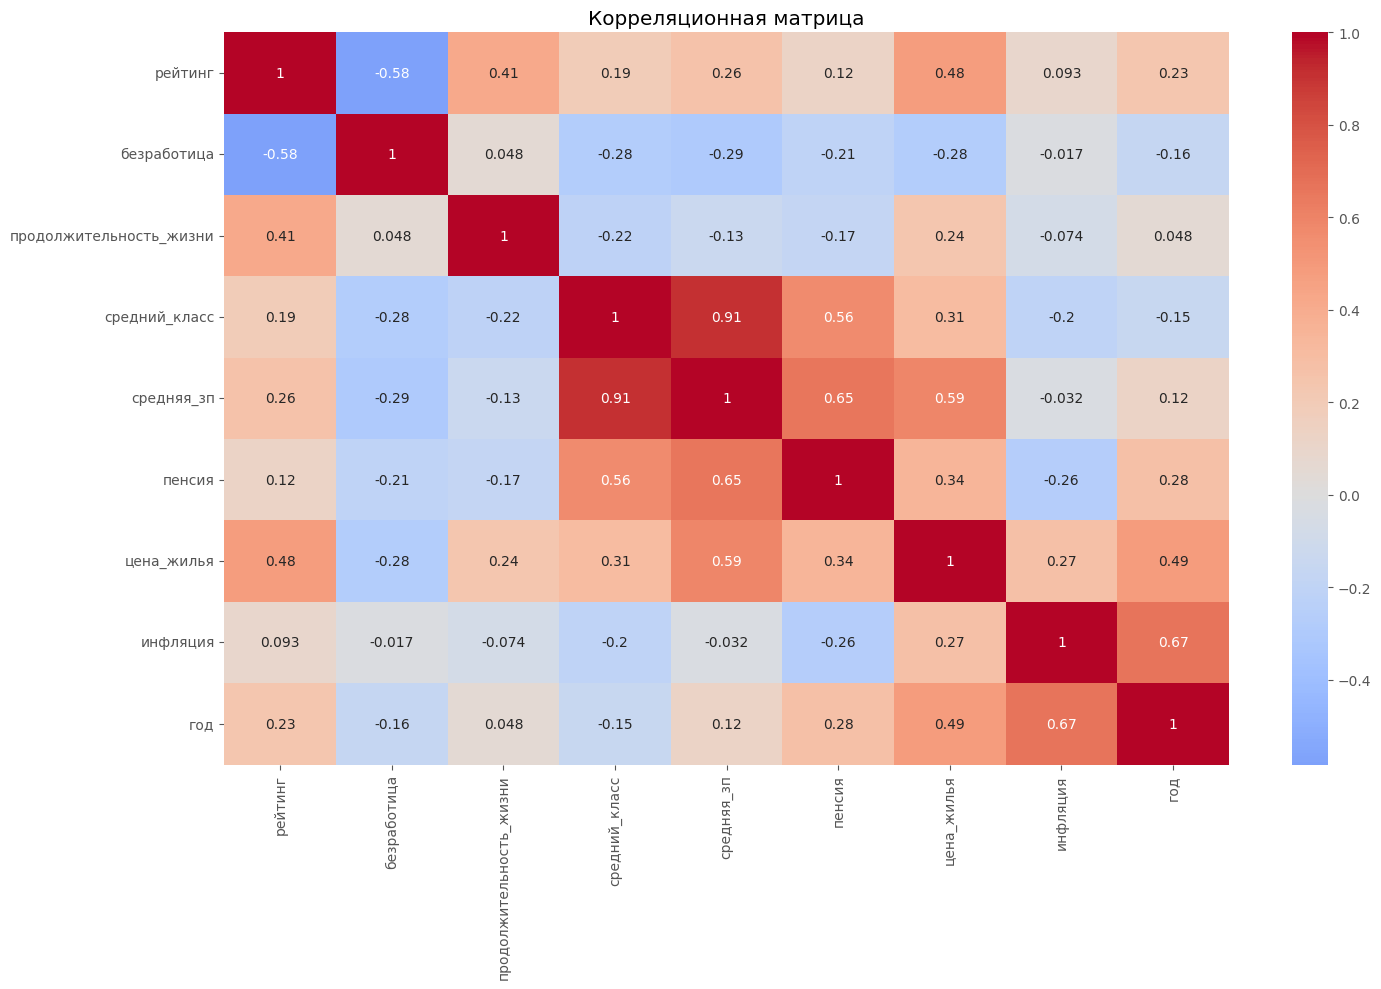

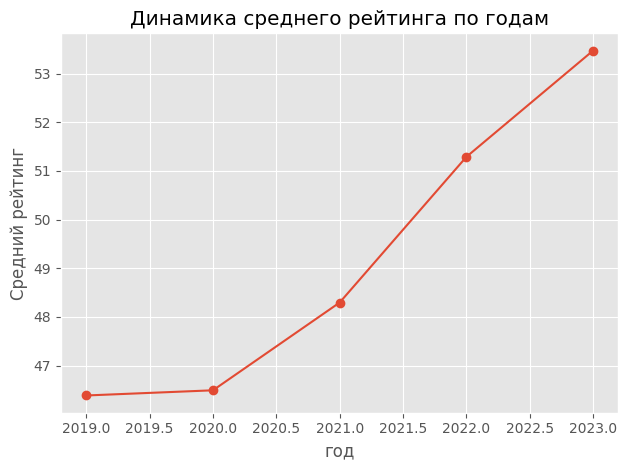

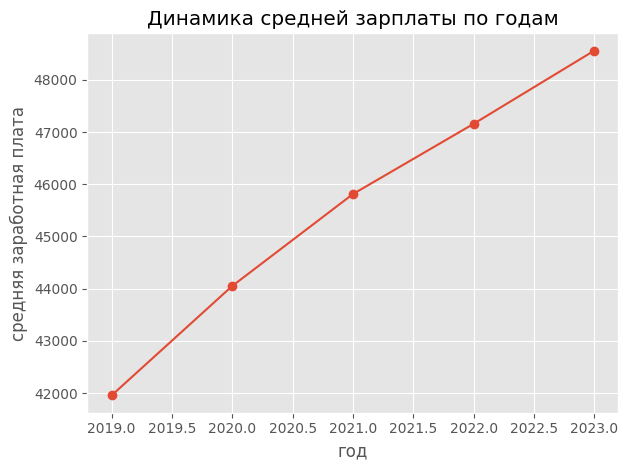

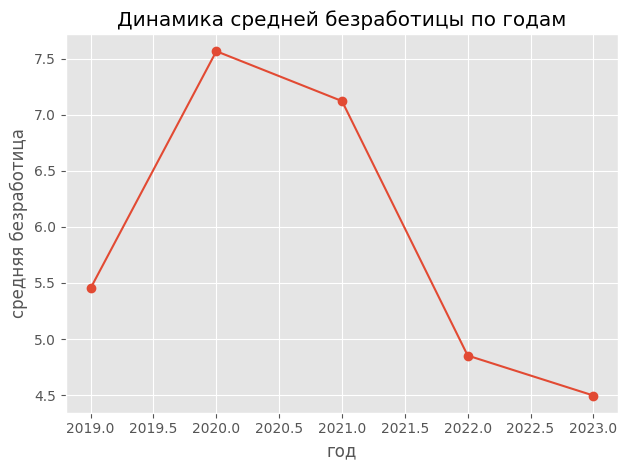

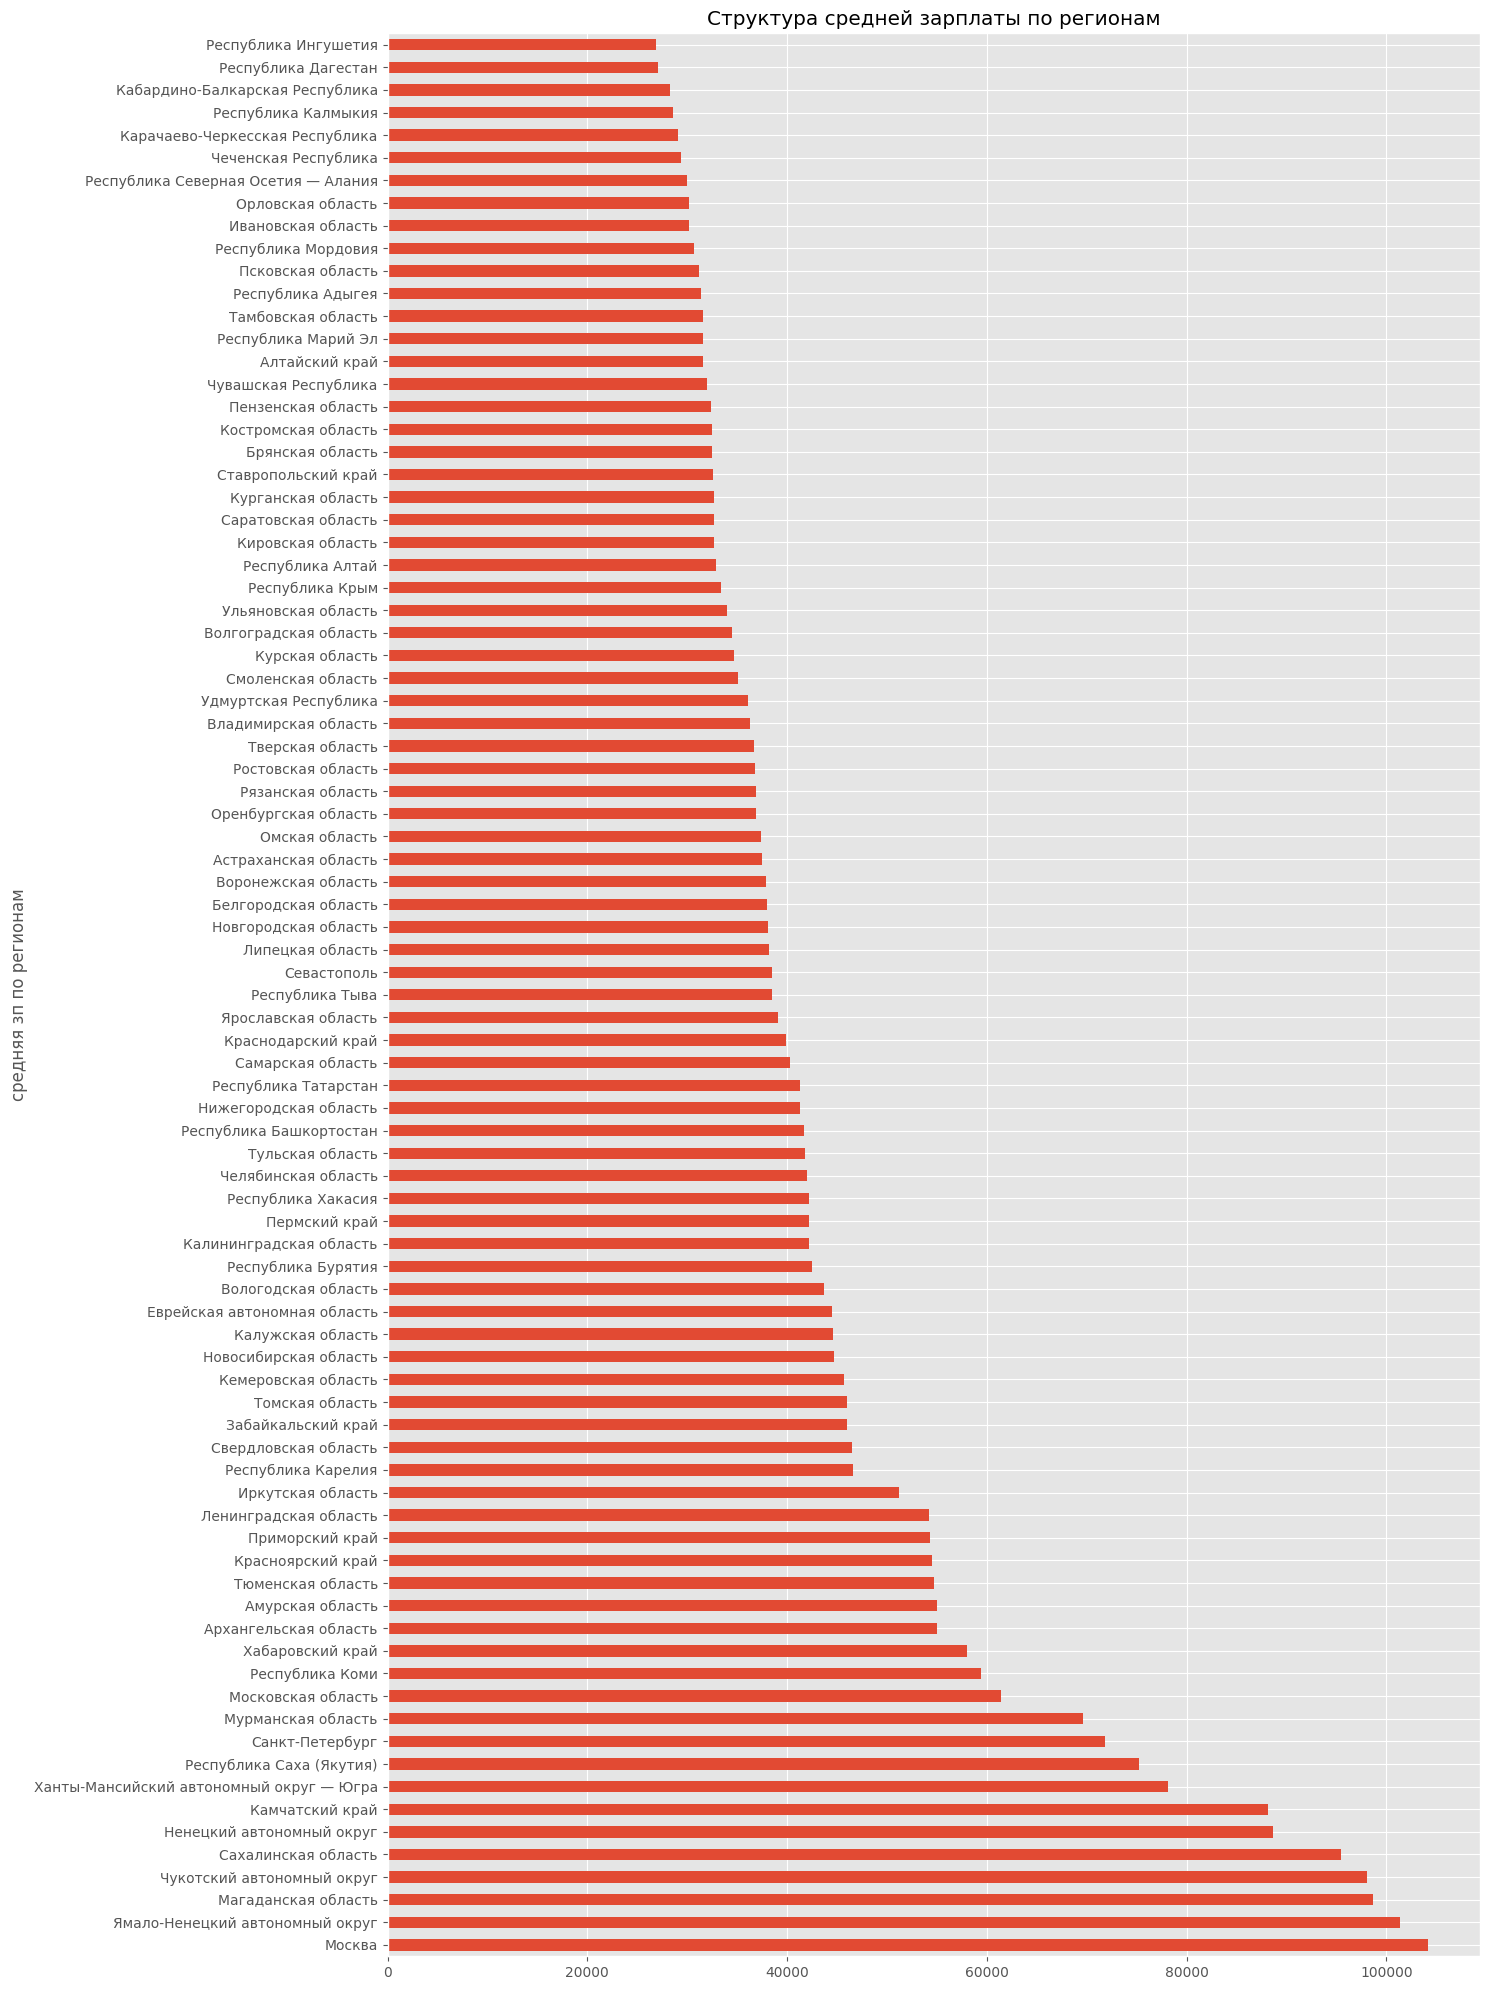


Результаты VIF-анализа:
                   Variable       VIF
0              безработица  1.118570
1  продолжительность_жизни  1.268019
2               средняя_зп  2.319470
3                   пенсия  1.911066
4               цена_жилья  2.183142
5                 инфляция  1.391653

Удалены переменные с высоким VIF: []

Результаты регрессионного анализа:
                          PanelOLS Estimation Summary                           
Dep. Variable:                рейтинг   R-squared:                        0.8369
Estimator:                   PanelOLS   R-squared (Between):              0.2090
No. Observations:                 420   R-squared (Within):               0.8369
Date:                Thu, Jun 19 2025   R-squared (Overall):              0.2499
Time:                        15:20:38   Log-likelihood                   -667.34
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      

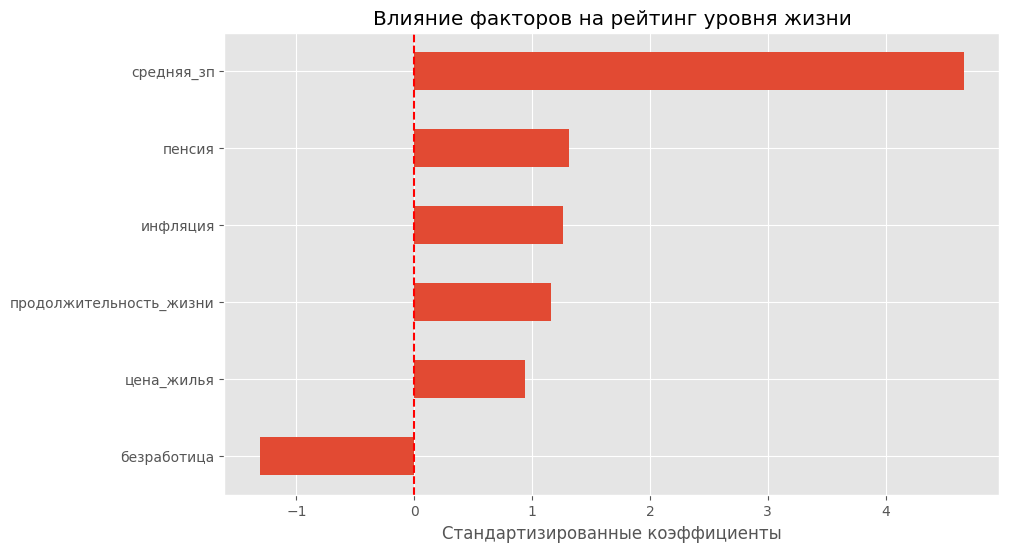

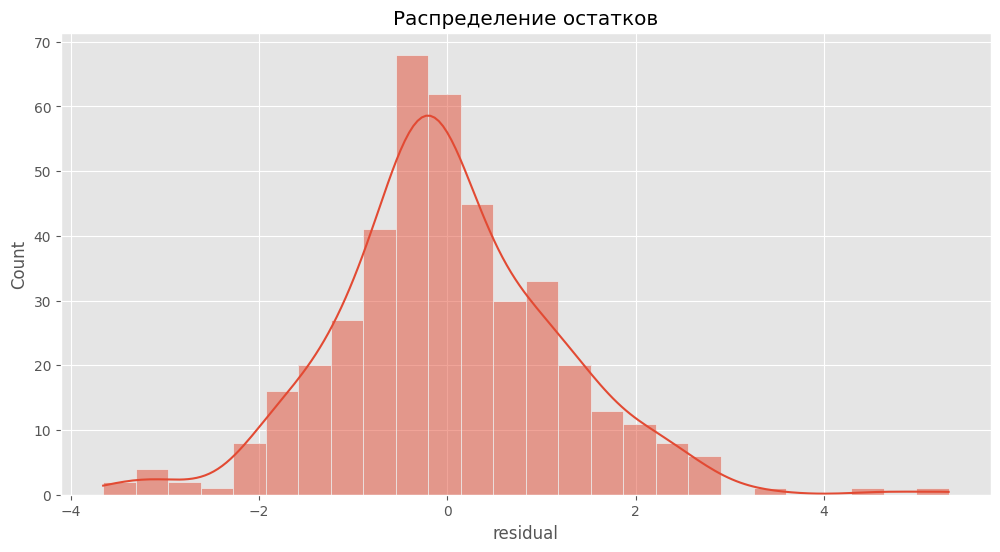

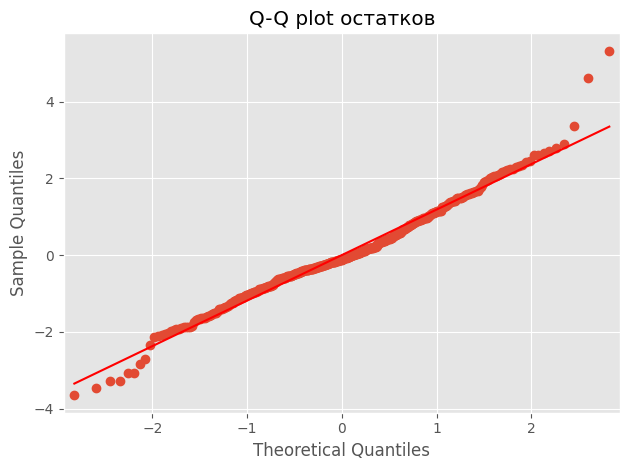

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from linearmodels import PanelOLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

# 1. Загрузка данных
df = pd.read_excel('статистика по регионам (3) доп.xlsx', sheet_name='данные')

# 2. Предварительная обработка данных
# Переименование столбцов для удобства
df.columns = ['Регион', 'рейтинг', 'безработица', 'продолжительность_жизни', 
              'средний_класс', 'средняя_зп','пенсия', 'цена_жилья', 'инфляция', 'год']

# Проверка пропущенных значений
print("Пропущенные значения:\n", df.isnull().sum())

# Заполнение пропусков медианными значениями
for col in ['цена_жилья']:
    df[col] = df.groupby('Регион')[col].transform(lambda x: x.fillna(x.median()))

# 3. Описательная статистика
print("\nОписательная статистика:\n", df.describe())

# 4. Визуализация данных
plt.figure(figsize=(15, 10))

# Распределение рейтинга по годам
#plt.subplot(1, 1, 1)
sns.boxplot(x='год', y='рейтинг', data=df)
plt.title('Распределение рейтинга уровня жизни по годам')
plt.tight_layout()
plt.show()
# Топ-10 регионов по рейтингу (среднее за все годы)
#plt.subplot(1, 1, 1)
plt.figure(figsize=(15, 10))
top_regions = df.groupby('Регион')['рейтинг'].mean().sort_values(ascending=False).head(10)
top_regions.plot(kind='bar')
plt.title('Топ-10 регионов по среднему рейтингу')
plt.tight_layout()
plt.show()
# Антитоп-10 регионов по рейтингу (среднее за все годы)
#plt.subplot(1, 1, 1)
plt.figure(figsize=(15, 10))
top_regions = df.groupby('Регион')['рейтинг'].mean().sort_values(ascending=True).head(10)
top_regions.plot(kind='bar')
plt.title('Антитоп-10 регионов по среднему рейтингу')
plt.tight_layout()
plt.show()
# Корреляционная матрица
#plt.subplot(1, 1, 1)
plt.figure(figsize=(15, 10))
corr_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица')
plt.tight_layout()
plt.show()
#df_panel = df_panel.drop('средний_класс', axis=1)

# Динамика среднего рейтинга по годам
#plt.subplot(1, 1, 1)
df.groupby('год')['рейтинг'].mean().plot(marker='o')
plt.title('Динамика среднего рейтинга по годам')
plt.ylabel('Средний рейтинг')

plt.tight_layout()
plt.show()
# Динамика средней зарплаты по годам
#plt.subplot(1, 1, 1)
df.groupby('год')['средняя_зп'].mean().plot(marker='o')
plt.title('Динамика средней зарплаты по годам')
plt.ylabel('средняя заработная плата')

plt.tight_layout()
plt.show()

# Динамика средней безработицы по годам
#plt.subplot(1, 1, 1)
df.groupby('год')['безработица'].mean().plot(marker='o')
plt.title('Динамика средней безработицы по годам')
plt.ylabel('средняя безработица')

plt.tight_layout()
plt.show()

# Структура средней зарплаты по регионам
#plt.subplot(1, 1, 1)
plt.figure(figsize=(15, 20))
df.groupby('Регион')['средняя_зп'].mean().sort_values(ascending=False).plot(kind='barh')
plt.title('Структура средней зарплаты по регионам')
plt.ylabel('средняя зп по регионам')

plt.tight_layout()
plt.show()




# 5. Подготовка данных для панельной регрессии
# Создание мультииндекса (Регион + год)
df_panel = df.set_index(['Регион', 'год'])

# Масштабирование числовых переменных (кроме года и рейтинга)
scaler = StandardScaler()
cols_to_scale = ['безработица', 'продолжительность_жизни', 'средняя_зп',
                'пенсия', 'цена_жилья', 'инфляция']
df_panel[cols_to_scale] = scaler.fit_transform(df_panel[cols_to_scale])

# 6. Проверка на мультиколлинеарность (VIF)
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) 
                      for i in range(data.shape[1])]
    return vif_data
    

vif_results = calculate_vif(df_panel[cols_to_scale].dropna())
print("\nРезультаты VIF-анализа:\n", vif_results)

# Удаление переменных с высоким VIF (>5)
high_vif = vif_results[vif_results["VIF"] > 5]["Variable"].tolist()
df_panel_clean = df_panel.drop(columns=high_vif)
print(f"\nУдалены переменные с высоким VIF: {high_vif}")

# 7. Построение панельной регрессионной модели
# Оставшиеся переменные
remaining_vars = list(set(cols_to_scale) - set(high_vif))
formula = 'рейтинг ~ 1 + ' + ' + '.join(remaining_vars) + ' + EntityEffects'

model = PanelOLS.from_formula(formula, data=df_panel_clean)
results = model.fit(cov_type='clustered', cluster_entity=True)

# 8. Вывод результатов регрессии
print("\nРезультаты регрессионного анализа:")Ы
print(results.summary)

# 9. Визуализация коэффициентов
plt.figure(figsize=(10, 6))
coefs = results.params.drop(['Intercept'])
coefs.sort_values().plot(kind='barh')
plt.title('Влияние факторов на рейтинг уровня жизни')
plt.xlabel('Стандартизированные коэффициенты')
plt.axvline(x=0, color='r', linestyle='--')
plt.show()

# 10. Анализ остатков модели
residuals = results.resids
plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
sns.histplot(residuals, kde=True)
plt.title('Распределение остатков')

plt.subplot(1, 1, 1)
sm.qqplot(residuals, line='s')
plt.title('Q-Q plot остатков')
plt.tight_layout()
plt.show()


In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from linearmodels import PanelOLS
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.api import omni_normtest
from statsmodels.stats.outliers_influence import reset_ramsey
import warnings

In [122]:
def prepare_for_diagnostics(model):
    """Преобразует результаты PanelOLS в формат для диагностических тестов"""
    # Получаем остатки и предсказанные значения
    resids = model.resids.values
    fitted = model.predict().values
    exog = model.model.exog.dataframe.values
    
    return resids, fitted, exog

In [124]:
resids, fitted, exog = prepare_for_diagnostics(results)

In [112]:
# Тест на гетероскедастичность
print("\nТест на гетероскедастичность (Breusch-Pagan):")
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
bp_test = het_breuschpagan(resids, exog)
print(dict(zip(labels, bp_test)))


# Тест Уайта на гетероскедастЫичность
print("\nТест Уайта на гетероскедастичность:")
white_test = het_white(resids, exog)
print(dict(zip(labels, white_test)))



Тест на гетероскедастичность (Breusch-Pagan):
{'LM Statistic': 13.212013654057085, 'LM-Test p-value': 0.039790009854167634, 'F-Statistic': 2.2364762735628974, 'F-Test p-value': 0.03900807808229613}

Тест Уайта на гетероскедастичность:
{'LM Statistic': 36.81196157520379, 'LM-Test p-value': 0.09863111895582419, 'F-Statistic': 1.3955996236864239, 'F-Test p-value': 0.0932883433466813}
